In [70]:
import pandas as pd
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import collections
import matplotlib.pyplot as plt
import seaborn as sns
#from greek_stemmer import GreekStemmer
import unicodedata
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
#from gensim.corpora import Dictionary
#from gensim.models.ldamodel import LdaModel
#import pyLDAvis.gensim
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.models import Sequential
#from keras.layers import Embedding, LSTM, Dense, Dropout
#from keras.layers import Flatten
#from keras.layers.convolutional import Conv1D
#from keras.layers.convolutional import MaxPooling1D
#from keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier

# Twitter

In [34]:
def twitterload():
    df = pd.read_csv('twitter.csv',names=['username', 'date', 'content'])
    return df

# Efood Load good, bad or everything

In [35]:
def efoodload(range):
    df = pd.read_csv('Efood.csv')
    df = df.dropna(subset = ['content'])
    df.userRating = df.userRating.apply(lambda x: round(x))
    if range == 'bad':
        df = df[df.userRating < 3]
    elif range == 'good':
        df = df[df.userRating > 4]
    df = df[['content', 'userRating']]
    return df

# TripAdvisor Load good, bad or everything

In [36]:
def tripLoad():
    df = pd.read_csv('TripAdvisor.csv')
    if range == 'bad':
        df = df[df.userRating < 3]
    elif range == 'good':
        df = df[df.userRating > 4]
    df = df[['content', 'userRating']]
    return df

# Balance data + add sentiment column

In [57]:
def balance(df,sentiment,num):
    ela = df.values.tolist()
    new = []
    fivec = 0
    fourc = 0
    threec = 0
    twoc = 0
    onec = 0
    for x in ela:
        if x[1] == 5 and fivec < num:
            new.append(x)
            fivec += 1
        elif x[1] == 4 and fourc < num and not sentiment:
            new.append(x)
            fourc += 1
        elif x[1] == 3 and threec < num and not sentiment:
            new.append(x)
            threec +=1
        elif x[1] == 2 and twoc < num:
            new.append(x)
            twoc += 1
        elif x[1] == 1 and onec < num:
            new.append(x)
            onec += 1
    df = pd.DataFrame(new,columns=['content','userRating'])
    if sentiment:
        df['Sentiment'] = [1 if x > 4 else 0 for x in df.userRating]
    return df

# Stop-Word removal from Nltk + custom array + <=3 word remove

In [38]:
moreStopWords = ['ΤΗΣ', 'ΑΠΟ', 'ΕΙΝΑΙ', 'ΜΟΥ', 'ΤΟΥΣ', 'ΜΑΣ', 'ΜΙΑ', 'ΣΤΑ', 'ΟΤΙ', 'ΕΝΑ', 'ΣΑΣ', 'ΣΟΥ', 'ΗΤΑΝ','της', 'απο', 'ειναι', 'μου', 'τους', 'μας', 'μια', 'στα', 'επισης','σου','εγω','εχει','εσυ','ενα','μολις','μπορει','σας','εχω','λεει','ηταν', 'οπως','κατι']
def removeStopwords(text):
    return [word for word in text if word not in stopwords.words('greek') and len(word) > 3 and word not in stopwords.words('english') and word not in moreStopWords]

# Remove any accent from greek lang. ex. Τονισμούς

In [39]:
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

# GreekStemmer

In [40]:
def greekStemmer(text):
    stemmer = GreekStemmer()
    return [stemmer.stem(x) for x in text]


# Lemmatizer

In [41]:
def lemmatizer(text):
    S =''
    for token in nlp(text):
        S = S + ' ' +str(token.lemma_)
    return S

# Example

In [58]:
df = efoodload('All')
df = balance(df,False,500)

# Preprocessing of the text

In [59]:
#Remove mentions
df.content = df.content.apply(lambda x: re.sub("@\S+", " ", x))
#Remove links
df.content = df.content.apply(lambda x: re.sub("https*\S+", " ", x))
#Remove hashtag
df.content = df.content.apply(lambda x: re.sub("#\S+", " ", x))
#Remove of "'"
df.content = df.content.apply(lambda x: re.sub("\'\w+", '', x))
df.content = df.content.apply(lambda x: re.sub(r'\w*\d+\w*', '', x))
#Strip accents
df.content = df.content.apply(lambda x : strip_accents(x))
#Tokenizer init
tokenizer = RegexpTokenizer(r'\w+')
#token + lower
df.content = df.content.apply(lambda x: tokenizer.tokenize(x.lower()))
#greekStemer
#df.content = df.content.apply(lambda x : greekStemmer(x))
#Lemmatizer
#df.content = df.content.apply(lambda x: lemmatizer(x))
#Stopwords
df.content = df.content.apply(lambda x : removeStopwords(x))
#if any content with 0 len return nan
df.content = df.content.apply(lambda x : np.nan if len(x) == 0 else x)
#drop nan
df = df.dropna(subset=['content'])
#Join tokens
df.content = df.content.apply(lambda x: " ".join(x))


# TF-IDF top 20 word plot

In [730]:
def tf_idf(df,siteName):
    content = df.content.tolist()
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(content)
    word_freq = dict(zip(vectorizer.get_feature_names(), np.asarray(vectors.mean(axis=0)).ravel()))
    word_counter = collections.Counter(word_freq)
    word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.barplot(x="word", y="freq", data = word_counter_df, palette = "crest", ax=ax)
    plt.xticks(rotation=60)
    plt.title('Tf-idf all reviews')
    plt.title('Tf-idf all reviews')
    plt.ylabel(siteName)
    plt.xlabel('Top-20 words.')
    plt.show()

# Split train-test

In [60]:
review_train, review_test, label_train, label_test = train_test_split(df.content, df.userRating, test_size=0.25, random_state = 20, stratify = df.userRating)

# Naive-Bayes + Confusion Matrix

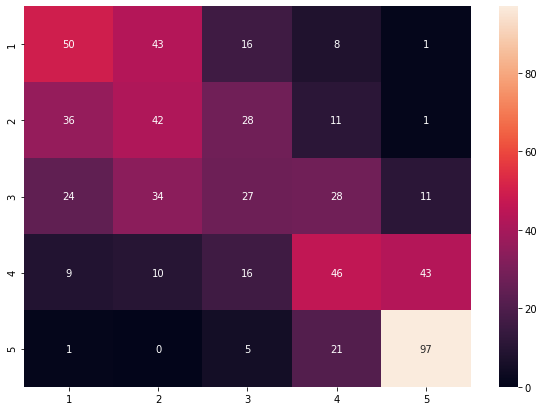

In [62]:
pipe = Pipeline([('Tf-Idf', CountVectorizer(ngram_range=(1,5))),('Naive', MultinomialNB())])
pipe.fit(review_train, label_train)
pred = pipe.predict(review_test)
array=confusion_matrix(label_test, pred)
if df.shape[1] == 2:
    numstr = '12345'
else:
    numstr = '123'
df_cm = pd.DataFrame(array, index = [i for i in numstr],columns = [i for i in numstr])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.show()

# Naive-Bayes Report

In [63]:
print(classification_report(label_test, pred))

              precision    recall  f1-score   support

           1       0.42      0.42      0.42       118
           2       0.33      0.36      0.34       118
           3       0.29      0.22      0.25       124
           4       0.40      0.37      0.39       124
           5       0.63      0.78      0.70       124

    accuracy                           0.43       608
   macro avg       0.41      0.43      0.42       608
weighted avg       0.42      0.43      0.42       608



# Logistic Regression + Classification Matrix

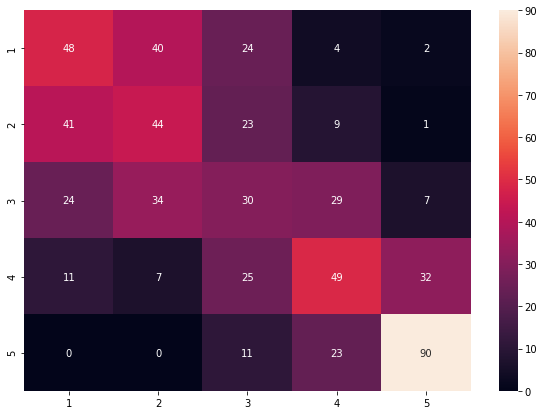

In [64]:
pipe = Pipeline([('Tf-Idf', TfidfVectorizer(ngram_range=(1,2))),('lr', LogisticRegression())])
pipe.fit(review_train, label_train)
pred = pipe.predict(review_test)
array=confusion_matrix(label_test, pred)
df_cm = pd.DataFrame(array, index = [i for i in "12345"],columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.show()

# Logistic Regression Report

In [65]:
print(classification_report(label_test, pred))

              precision    recall  f1-score   support

           1       0.39      0.41      0.40       118
           2       0.35      0.37      0.36       118
           3       0.27      0.24      0.25       124
           4       0.43      0.40      0.41       124
           5       0.68      0.73      0.70       124

    accuracy                           0.43       608
   macro avg       0.42      0.43      0.43       608
weighted avg       0.42      0.43      0.43       608



# SVD + Classification Matrix

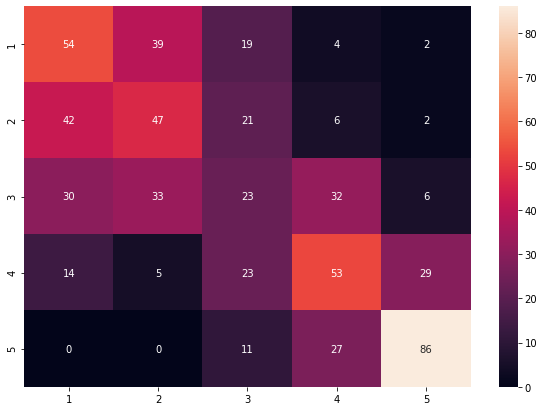

In [71]:
pipe = Pipeline([('Tf-Idf', TfidfVectorizer(ngram_range=(1,4))),('SVD',  SGDClassifier())])
pipe.fit(review_train, label_train)
pred = pipe.predict(review_test)
array=confusion_matrix(label_test, pred)
df_cm = pd.DataFrame(array, index = [i for i in "12345"],columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.show()

# SVD Report

In [72]:
print(classification_report(label_test, pred))

              precision    recall  f1-score   support

           1       0.39      0.46      0.42       118
           2       0.38      0.40      0.39       118
           3       0.24      0.19      0.21       124
           4       0.43      0.43      0.43       124
           5       0.69      0.69      0.69       124

    accuracy                           0.43       608
   macro avg       0.42      0.43      0.43       608
weighted avg       0.43      0.43      0.43       608



# Usage of CNN 

In [73]:
def CNN(df):
    X, y = (df['content'].values, df['Sentiment'].values)
    tk = Tokenizer(lower = True)
    tk.fit_on_texts(X)
    X_seq = tk.texts_to_sequences(X)
    X_pad = pad_sequences(X_seq, maxlen=600, padding='post')
    X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.25, random_state = 1)
    batch_size = 100
    vocabulary_size = len(tk.word_counts.keys())+1
    print(vocabulary_size)
    max_words = 600
    embedding_size = 128
    model = Sequential()
    model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
    model.add(Conv1D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=600))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size= batch_size, epochs = 3)
    scores = model.evaluate(X_test,y_test, verbose = 0)
    y_pred = model.predict(X_test)
    print(model.summary())
    print("Accuracy: %.2f%%" % (scores[1]*100))
CNN(df)

KeyError: 'Sentiment'

# Usage of LDA

In [155]:
def lda(df):
    text_dict = Dictionary(df.content)
    tweets_bow = [text_dict.doc2bow(tweet) for tweet in df['content']]
    k = 5
    tweets_lda = LdaModel(tweets_bow,num_topics = k,id2word = text_dict,random_state = 1,passes=10)
    print(tweets_lda.show_topics())
#lda(cleanData(efoodload('fr')))


# Most used hashtags on Twitter

In [23]:
df = pd.read_csv('twitter.csv',names=['username', 'date', 'content'])
df = df.drop_duplicates()
df = df.content.str.findall(r'#.*?(?=\s|$)')
tag = {}
def ela(x):
    for item in x:
        if str(item).lower() not in tag:
            tag[str(item).lower()] = 1
        else:
            tag[str(item).lower()] = tag[str(item).lower()] + 1
df.apply(lambda x: ela(x))
for w in sorted(tag, key=tag.get, reverse=True):
    print(w, tag[w])



#ioannina 1158
#greece 723
#epirus 366
#dokcreations 215
#lake 212
#ioanninacity 185
#sonyalpha 183
#nature 161
#photography 158
#sony 147
#portrait 137
#earthquake 136
#nofilter 135
#dok🎈 126
#streetphotography 124
#people 107
#summer 98
#village 98
#selfie 93
#survivorgr 90
#love 88
#pasgiannina 86
#sky 84
#headshot 84
#endomondo 84
#endorphins 84
#coffee 82
#io�nnina 82
#quiz 82
#photo 81
#friends 81
#retouch 81
#pas 80
#travel 80
#headshots 78
#bigbrothergr 74
#pasgianninafc 74
#photographer 72
#life_is_street 70
#sonya7 70
#ioannina… 70
#greece… 69
#rural 69
#weekend 68
#sonya7iii 66
#ioannina_greece 66
#agriesmelisses 64
#nickvous 62
#νονα 61
#instagood 61
#myrodafni 61
#halitergenç 61
#giannena 59
#photoshoot 59
#smile 58
#photos 58
#masterchefgr 57
#autumn 57
#nofilterneeded 57
#portraits 56
#image 55
#photooftheday 54
#model 54
#pamvotis 54
#sonyphotography 54
#morning 54
#blackandwhite 53
#happy 52
#images 52
#portraitphotography 50
#latergram 50
#spring 50
#winter 49
#style 

#bnw_captures 3
#bnw_mood… 3
#sonyalpha7 3
#in 3
#drauholz 3
#addicted 3
#merry 3
#photomind 3
#learning 3
#doublexposure 3
#church 3
#etwinconfgr 3
#vnv 3
#vassiliosnicolaosvitsilogiannis 3
#journalist 3
#malemodel 3
#media 3
#photshoot 3
#ottoman 3
#it 3
#necklace 3
#bicycle 3
#stars 3
#eye 3
#flowers… 3
#oneteam 3
#konitsa 3
#streetphotographerscommunity… 3
#grecce 3
#unique 3
#wildflower 3
#realfm 3
#radio 3
#kalamas 3
#portra400 3
#sunset_greece 3
#diaperbag 3
#stonebridge 3
#june… 3
#house… 3
#prismalove 3
#spring… 3
#architecture… 3
#onlylove 3
#djdoctorioannina… 3
#freedom 3
#tango_sentimental 3
#tv 3
#daretodream 3
#bass 3
#fireplace 3
#teamashigaru 3
#instafoto 3
#old_door 3
#bwphotography 3
#rise 3
#sunrise 3
#festival 3
#tgif 3
#street… 3
#drinking 3
#voidomatis 3
#germany 3
#delicious… 3
#mono 3
#slowmotion 3
#2017 3
#fethiye 3
#summeringreece 3
#like4like 3
#waterski 3
#solarcollectors 3
#lastnight 3
#havefun 3
#xhtosluxuryhall 3
#hello 3
#grecia… 3
#pet 3
#natural 3
#cou

#burningman… 1
#warmup 1
#παιδωναγιασοφια2 1
#φθινωπορο… 1
#κορδελαμαλλιων 1
#κορονοϊο. 1
#euregion 1
#juan 1
#dominguez 1
#hotoriced 1
#beginningoftheday 1
#αει 1
#πανελλαδικές 1
#γαβρογλου 1
#παοκ 1
#paokbes 1
#baypsg 1
#uclfinal2020 1
#γεφυρι 1
#μισιου 1
#βικος 1
#ελλας 1
#missios 1
#gorge 1
#worldofwarcraft 1
#shadowlands 1
#shadowsrising 1
#team_singles 1
#kleidonia 1
#peloponnese 1
#sevillavsmanunited 1
#sevmun 1
#collectivelycreate 1
#theoutbound 1
#in2nature 1
#folkcreative 1
#visualsofearth 1
#greatnorthcollective 1
#campingcollective 1
#travelstoke 1
#keepitwild… 1
#oruc_reis 1
#νδ_χουντα 1
#νδ_απατεωνες 1
#νδ_προδοτες 1
#kyriafrosini 1
#dinnerbeer 1
#sonyalphaclub… 1
#sdltrados 1
#smartcat 1
#trados) 1
#photographyislifee… 1
#πασοκ 1
#kinimaallagis 1
#wetherural 1
#marvin 1
#peersman 1
#pedini, 1
#gtptravelgreece 1
#ioanninahotels 1
#summerinioannina 1
#theasisigloo 1
#igloo 1
#startrails 1
#startrailsphotography 1
#nightsky 1
#lightpainting 1
#lightpaintingphotography 1
#su

#krombooks 1
#instabooks 1
#vivlio 1
#vivlia 1
#summerbooks 1
#dioptrabooks 1
#mirodiaaposanidi 1
#metalmusic 1
#λοΐζου 1
#παραιτηση 1
#πολάκης: 1
#braingain: 1
#uploadfilter. 1
#article13 1
#siarava 1
#γιάνεννα. 1
#filmisalive 1
#paooly 1
#βενεζουέλα) 1
#sagapaoalla 1
#aimiliosraftis 1
#actor 1
#starring 1
#acting 1
#panpaok 1
#paslar 1
#playforthegame 1
#matchday25 1
#frames#woodenwindows 1
#snapseed 1
#parfumes 1
#comparison 1
#choice 1
#mansperfumes 1
#fetashow 1
#fetanews 1
#fetapdo 1
#letsgetreal 1
#greekcheese 1
#cheesemaking 1
#dairyschool 1
#feta 1
#graviera 1
#talagani… 1
#footballisthedrug 1
#stadiumgraffiti 1
#streetartlovers 1
#ioanninagraffiti 1
#nationalstadiumofioannina 1
#stadium… 1
#cobbledstreets 1
#kastroioannina 1
#castleofioannina 1
#travelioannina 1
#lp 1
#timebikes 1
#lovestrays 1
#straycatsofgreece 1
#beautifulcreatures 1
#reeds 1
#athamanika 1
#snowcappedmountains… 1
#islandwithnoname 1
#islandlife… 1
#λαζόπουλο 1
#juvatl 1
#kitchen#classickitchen#design 1
#dr

#hotinside 1
#itscoldoutside 1
#phototour 1
#dimitrisgiouvris 1
#iphone 1
#zagoriphototour… 1
#filmborn 1
#adoredelano 1
#myadressishollywood… 1
##foodporn 1
#highway 1
#ionianhighway 1
#empty 1
#fall… 1
#ioannian 1
#kill 1
#cloud… 1
#height… 1
#lesfaullesmortes 1
#autumnleaves 1
#eat_taste_delightsnack 1
#χωριατικο 1
#distillation 1
#spirit 1
#pork 1
#onlyfresh 1
#foodvideo 1
#bonapetit 1
#lovethiscity 1
#geometry… 1
#panseta 1
#αραβικη 1
#ouija 1
#ouijamovie 1
#originofevil 1
#aftermidnight… 1
#corridor 1
#turbine 1
#strolling 1
#restart 1
#glikeskalinixtes 1
#gamwtasavvata 1
#photogramma_eisai… 1
#guard 1
#mygirls 1
#photogramma_eisai 1
#tommorrow 1
#ktelioanninwn 1
#goingbackhome 1
#fortheweekend 1
#bored… 1
#greytone 1
#apoelfc 1
#apoelnicosia 1
#monoapoel 1
#high 1
#joint 1
#psicodelic… 1
#pastaday#miammiamioannina#resto#food#lovepasta 1
#3826 1
#28οκτωβρίου 1
#soldout❌❌❌ 1
#anotherone 1
#vrettour2016… 1
#ψηφιακόσνομάς 1
#ψηφιακός 1
#νομάς 1
#bluesky… 1
#greece2016 1
#fiftyfifty 

#myathletegr 1
#myteam 1
#door, 1
#vroxi 1
#not… 1
#proti 1
#proti_fora_aristero_mnimonio 1
#notherngreece. 1
#frontzos 1
#ehm 1
#πατσαρωθήκαμε 1
#κάμα 1
#hayesphotobryant 1
#onemore 1
#look 1
#lastday 1
#vibes… 1
#sushibar 1
#protectaoosmtbultra 1
#root 1
#120k 1
#mtbrace 1
#mtbultra… 1
#birthdayboy 1
#withmygirl 1
#dinnerbythelake 1
#35 1
#agiaparaskevi 1
#vovousa4season 1
#rest 1
#time… 1
#summertour2015 1
#otherviewteam 1
#lovegiannena 1
#liveshowtoday… 1
#tragedy 1
#cultural 1
#heritage 1
#csrracing 1
#greece, 1
#bridges, 1
#giannena, 1
#vsco_cam… 1
#🎂 1
#i_love_you 1
#dayoff!! 1
#sister 1
#chopsticks 1
#foodstyling 1
#skitso 1
#umbrella 1
#sunrise_cocktails 1
#bmx 1
#crafty 1
#nonono 1
#jazz 1
#sunbathing 1
#noclouds 1
#tzami… 1
#childhood 1
#fear 1
#ghost 1
#sillysmallgirl 1
#nofear… 1
##friends 1
#another 1
#lines… 1
#atm 1
#atm's 1
#wonderful 1
#cloudysky 1
#road. 1
#sky. 1
#tvseires 1
#ross 1
#joe 1
#rachel 1
#delicious#by 1
#time4_16 1
#grandfather 1
#oka 1
#drachma 1
#drx 1